In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import copy
import random

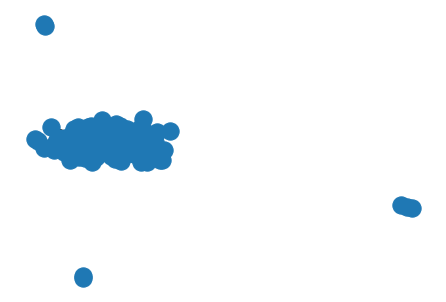

In [4]:
G = nx.read_adjlist("/Users/danielluo/School/Senior Year/Math 168/socfb-Caltech36.mtx.txt")

nx.draw(G)

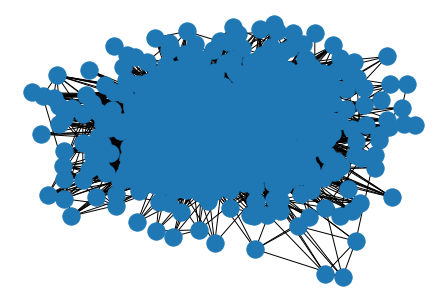

In [14]:
G_5_core = nx.algorithms.core.k_core(G, k=5)

nx.draw(G_5_core)

Cool so this is how the current k core algorithm works very nice.

## Saving Nodes and Edges

Let's trace the below code and see how it works

In [17]:
def core_number(G):
    """Returns the core number for each vertex.

    A k-core is a maximal subgraph that contains nodes of degree k or more.

    The core number of a node is the largest value k of a k-core containing
    that node.

    Parameters
    ----------
    G : NetworkX graph
       A graph or directed graph

    Returns
    -------
    core_number : dictionary
       A dictionary keyed by node to the core number.

    Raises
    ------
    NetworkXError
        The k-core is not implemented for graphs with self loops
        or parallel edges.

    Notes
    -----
    Not implemented for graphs with parallel edges or self loops.

    For directed graphs the node degree is defined to be the
    in-degree + out-degree.

    References
    ----------
    .. [1] An O(m) Algorithm for Cores Decomposition of Networks
       Vladimir Batagelj and Matjaz Zaversnik, 2003.
       https://arxiv.org/abs/cs.DS/0310049
    """
    
    # this code will not run if there are self edges
    if nx.number_of_selfloops(G) > 0:
        msg = (
            "Input graph has self loops which is not permitted; "
            "Consider using G.remove_edges_from(nx.selfloop_edges(G))."
        )
        raise NetworkXError(msg)
        
    
    degrees = dict(G.degree())# This is a dict of 'node num':degree
    # Sort nodes by degree.
    # this a list of the number of the node ranked from degree low to high
    nodes = sorted(degrees, key=degrees.get)
    bin_boundaries = [0]
    curr_degree = 0
    for i, v in enumerate(nodes): # enumerate gives them each an index so i is the index and v is the node
        if degrees[v] > curr_degree:
            bin_boundaries.extend([i] * (degrees[v] - curr_degree)) # everytime it gets bigger multiply the index by the amount increase
            curr_degree = degrees[v] # eventually becomes the max degree but increases everytime the degree increases
    node_pos = {v: pos for pos, v in enumerate(nodes)} # creates a dict 'node_num':position in list
    
    # The initial guess for the core number of a node is its degree.
    core = degrees
    nbrs = {v: list(nx.all_neighbors(G, v)) for v in G} # creates a dict that's node_num and a list of the node num of neighbors
    for v in nodes: # for each node v in nodes that sorted low to high by degree
        for u in nbrs[v]: # for each of v's neighbors called u
            if core[u] > core[v]: # if it's neighbor (u) has a greater degree than the current node(v)
                nbrs[u].remove(v) # remove v as a neighbor of u
                pos = node_pos[u] # set position to the position of u
                bin_start = bin_boundaries[core[u]] # bin boundary at the degree of node u
                node_pos[u] = bin_start
                node_pos[nodes[bin_start]] = pos
                nodes[bin_start], nodes[pos] = nodes[pos], nodes[bin_start]
                bin_boundaries[core[u]] += 1
                core[u] -= 1
    return core

In [50]:
degrees = dict(G.degree())
nodes = sorted(degrees, key=degrees.get)
bin_boundaries = [0]
curr_degree = 0
for i, v in enumerate(nodes): # enumerate gives them each an index so i is the index and v is the node
    if degrees[v] > curr_degree:
        bin_boundaries.extend([i] * (degrees[v] - curr_degree))
        curr_degree = degrees[v]

{'318': 0,
 '34': 1,
 '147': 2,
 '35': 3,
 '583': 4,
 '184': 5,
 '75': 6,
 '704': 7,
 '99': 8,
 '100': 9,
 '111': 10,
 '123': 11,
 '221': 12,
 '297': 13,
 '507': 14,
 '163': 15,
 '360': 16,
 '437': 17,
 '169': 18,
 '182': 19,
 '207': 20,
 '372': 21,
 '708': 22,
 '264': 23,
 '272': 24,
 '306': 25,
 '317': 26,
 '401': 27,
 '394': 28,
 '744': 29,
 '531': 30,
 '581': 31,
 '533': 32,
 '536': 33,
 '713': 34,
 '11': 35,
 '74': 36,
 '13': 37,
 '106': 38,
 '262': 39,
 '204': 40,
 '19': 41,
 '751': 42,
 '40': 43,
 '474': 44,
 '527': 45,
 '629': 46,
 '92': 47,
 '94': 48,
 '426': 49,
 '269': 50,
 '410': 51,
 '159': 52,
 '662': 53,
 '206': 54,
 '501': 55,
 '398': 56,
 '363': 57,
 '566': 58,
 '693': 59,
 '428': 60,
 '300': 61,
 '505': 62,
 '456': 63,
 '743': 64,
 '633': 65,
 '540': 66,
 '9': 67,
 '37': 68,
 '24': 69,
 '403': 70,
 '68': 71,
 '121': 72,
 '402': 73,
 '684': 74,
 '542': 75,
 '172': 76,
 '181': 77,
 '326': 78,
 '324': 79,
 '597': 80,
 '712': 81,
 '7': 82,
 '237': 83,
 '193': 84,
 '504': 

They use the degree as the max of the biggest k it can belong to

I think using the above code is not the move. Its not simple to adjust for our use case. I'll instead code one myself that will be probably quite slow but that's okay.

## Individual Implementation of Normal K Core

In [103]:
def original_k_core(G, k):
    k_core_subgraph = copy.deepcopy(G)
    
    # This goes through and just removes a node if its degree is less than k
    while not all(val >= k for val in dict(k_core_subgraph.degree()).values()):
        for node_num, degree in dict(k_core_subgraph.degree()).items():
            if degree < k:
                k_core_subgraph.remove_node(node_num)
            
    return k_core_subgraph

## Implementation of Modified K Core by Saving an Edge Each time

In [32]:
def modified_k_core_save_an_edge(G, k):
    k_core_subgraph = copy.deepcopy(G)
    
    # This goes through and just removes a node if its degree is less than k
    while not all(val >= k for val in dict(k_core_subgraph.degree()).values()):
        potential_weighted_deletions = []
        for node_num, degree in dict(k_core_subgraph.degree()).items():
            if degree < k:
                # add nodes to list based on their degree
                potential_weighted_deletions += [node_num] * degree
        nodes_to_delete = set(potential_weighted_deletions)
        # randomly choose an edge belonging to a node
        saved_node = random.choice(potential_weighted_deletions)
        # list of neighbors
        saved_node_neighbors = set([n for n in k_core_subgraph.neighbors(saved_node)])
        neighbor_candidates_to_save = saved_node_neighbors.difference(nodes_to_delete)
        selected_saved_node_neighbor = random.choice(list(neighbor_candidates_to_save))
        # turn it into a set to remove duplicates
        k_core_subgraph.remove_nodes_from(nodes_to_delete)
#         print(nodes_to_delete)
        if len(nodes_to_delete) > 1:
            k_core_subgraph.add_node(saved_node)
            k_core_subgraph.add_edge(saved_node, selected_saved_node_neighbor)
    return k_core_subgraph

In [33]:
subgraph = modified_k_core_save_an_edge(G, 5)

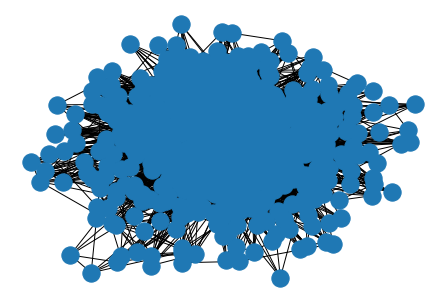

In [35]:
nx.draw(subgraph)

## Saving Edges

In [13]:
random.choice(list(set([n for n in G.neighbors('4')])))

'555'

In [ ]:
def modified_k_core_save_a_node(G, k):
    k_core_subgraph = copy.deepcopy(G)
    
    # This goes through and just removes a node if its degree is less than k
    while not all(val >= k for val in dict(k_core_subgraph.degree()).values()):
        potential_weighted_deletions = []
        for node_num, degree in dict(k_core_subgraph.degree()).items():
            if degree < k:
                # add nodes to list based on their degree
                potential_weighted_deletions += [node_num] * degree
                # randomly choose one to save
                saved_node = random.choice(potential_weighted_deletions)
                # turn it into a set to remove duplicates
                nodes_to_delete = set(potential_weighted_deletions)
                if len(nodes_to_delete) > 1: # it won't converge if there's only one node left to delete, in this case just delete it
                    nodes_to_delete.remove(saved_node)
                k_core_subgraph.remove_nodes_from(nodes_to_delete)
            
    return k_core_subgraph

In [140]:
subgraph = modified_k_core_save_a_node(G, 5)

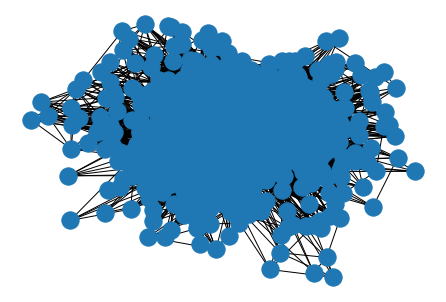

In [142]:
nx.draw(subgraph)